# Importing Libraries

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from einops import rearrange

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Hyperparameters

In [2]:
# Patch size = P
# context size = T
# Number of patches = K = T/P
# global embedding dimension = d_G
# local embedding dimension = d_L

In [3]:
@dataclass
class CONFIG:
    debug: bool = False
    
    # Model
    V: int = 512  # 258 utf-8 characters + 2 special tokens
    P: int = 4
    T: int = 1024
    K: int = T // P  # Number of patches
    
    model_size: str = 'small'  # 'small' or 'large'
    
    ## Small
    if model_size == 'small':
        ### Global model
        n_layers_G: int = 6
        n_heads_G: int = 4
        d_G: int = 128
        d_head_G: int = d_G // n_heads_G
        d_ff_G: int = d_G * 4
        dropout_G: float = 0.1
        ### Local model
        n_layers_L: int = 4
        n_heads_L: int = 4
        d_L: int = 64
        d_head_L: int = d_L // n_heads_L
        d_ff_L: int = d_L * 4
        dropout_L: float = 0.1
    ### Large
    elif model_size == 'large':
        ### Global model
        n_layers_G: int = 12
        n_heads_G: int = 8
        d_G: int = 256
        d_head_G: int = d_G // n_heads_G
        d_ff_G: int = d_G * 4
        dropout_G: float = 0.1
        ### Local model
        n_layers_L: int = 8
        n_heads_L: int = 8
        d_L: int = 128
        d_head_L: int = d_L // n_heads_L
        d_ff_L: int = d_L * 4
        dropout_L: float = 0.2
    
    flash_attention: bool = False
    
    # Vocabulary
    PAD_ID: int = 256
    EOS_ID: int = 257
    
    # data
    validation_size: float = 0.2
    
    # Device
    device: torch.device = None
    
    # Training
    epochs: int = 10
    batch_size: int = 128
    learning_rate: float = 2e-5
    
    # Generation
    max_len: int = 8192
    temperature: float = 1.0
    
    # Seed
    seed: int = 101

# Reproducibility

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"Seed: {seed}")
    
set_seed(CONFIG.seed)

Seed: 101


# Device

In [5]:
def configure_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        num_gpu = torch.cuda.device_count()
        print("> Running on GPU", end=' | ')
        print("Num of GPUs: ", num_gpu)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("> Running on MPS")
    else:
        device = torch.device("cpu")
        print("> Running on CPU")
    return device

CONFIG.device = configure_device()

> Running on GPU | Num of GPUs:  1


# Debug

In [6]:
if CONFIG.debug:
    CONFIG.epochs = 1
    CONFIG.max_len = 2000

# Dataset

In [7]:
# data path
dataset_path = 'data/'
# shakespeare data
shakespeare_dataset = dataset_path + 'shakespeare.txt'

In [8]:
# read the dataset
with open(shakespeare_dataset, 'r', encoding='utf-8') as f:
    shakespeare_text = f.read()

In [9]:
print(shakespeare_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [10]:
print(f'Total number of characters in the text: {len(shakespeare_text)}')

Total number of characters in the text: 1115394


# Vocabulary

In [11]:
char2int = {chr(i): i for i in range(CONFIG.V)}
int2char = {i: chr(i) for i in range(CONFIG.V)}

PAD_TOKEN = '<PAD>'
char2int[PAD_TOKEN] = CONFIG.PAD_ID
int2char[CONFIG.PAD_ID] = PAD_TOKEN
EOS_TOKEN = '<EOS>'
char2int[EOS_TOKEN] = CONFIG.EOS_ID
int2char[CONFIG.EOS_ID] = EOS_TOKEN

In [12]:
def encode(text):
    return [char2int[c] for c in text]

def decode(tokens):
    return ''.join([int2char[t] for t in tokens])

In [13]:
sample_text = "Hello, World!" + EOS_TOKEN
sample_tokens = encode(sample_text)
print(sample_tokens)
print(decode(sample_tokens))

[72, 101, 108, 108, 111, 44, 32, 87, 111, 114, 108, 100, 33, 60, 69, 79, 83, 62]
Hello, World!<EOS>


In [14]:
shakespeare_tokens = torch.tensor(encode(shakespeare_text))

# Preprocessing

In [15]:
# Train Validation Split
train_size = int(len(shakespeare_tokens) * (1 - CONFIG.validation_size))
train_tokens = shakespeare_tokens[:train_size]
validation_tokens = shakespeare_tokens[train_size:]
print(f'Total number of tokens in the training set: {len(train_tokens)}')
print(f'Total number of tokens in the validation set: {len(validation_tokens)}')

Total number of tokens in the training set: 892315
Total number of tokens in the validation set: 223079


In [16]:
class ShakespeareDataset(Dataset):
    def __init__(self, tokens, context_length):
        self.tokens = tokens
        self.context_length= context_length
        
    def __len__(self):
        return len(self.tokens) - self.context_length
    
    def __getitem__(self, idx):
        return self.tokens[idx:idx+self.context_length], self.tokens[idx+1:idx+self.context_length+1]

train_dataset = ShakespeareDataset(train_tokens, CONFIG.T)
validation_dataset = ShakespeareDataset(validation_tokens, CONFIG.T)
train_loader = DataLoader(train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=CONFIG.batch_size, shuffle=False)

In [17]:
sample_x, sample_y = next(iter(train_loader))
sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
print(sample_x.shape, sample_y.shape)
print(sample_x[0])
print(sample_y[0])

torch.Size([128, 1024]) torch.Size([128, 1024])
tensor([101, 110, 115,  ...,  97, 110,  32], device='cuda:0')
tensor([110, 115, 107,  ..., 110,  32, 119], device='cuda:0')


# Model

## Transformer

In [18]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_embed: int, n_heads: int, d_head: int):
        super().__init__()
        self.d_embed = d_embed
        self.n_heads = n_heads
        self.d_head = d_head
        
        self.query = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.key = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.value = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.out = nn.Linear(self.n_heads * self.d_head, self.d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        batch_size, context_size, _ = x.size()
        q = self.query(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        k = self.key(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        v = self.value(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        
        q = q.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        k = k.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        v = v.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        
        # Masked Self Attention
        mask = torch.triu(torch.ones(context_size, context_size, device=x.device), diagonal=1).bool()  # [context_size, context_size]
        mask = mask.view(1, 1, context_size, context_size)  # [1, 1, context_size, context_size]
        mask = mask.repeat(batch_size, self.n_heads, 1, 1)  # [batch_size, n_heads, context_size, context_size]
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_head ** 0.5)  # [batch_size, n_heads, context_size, context_size]
        scores = scores.masked_fill(mask, float('-inf'))  # [batch_size, n_heads, context_size, context_size]
        scores = F.softmax(scores, dim=-1)  # [batch_size, n_heads, context_size, context_size]
        
        x = torch.matmul(scores, v)  # [batch_size, n_heads, context_size, d_head]
        x = x.transpose(1, 2).contiguous().view(batch_size, context_size, self.n_heads * self.d_head)  # [batch_size, context_size, n_heads * d_head]
        x = self.out(x)  # [batch_size, context_size, d_embed]
        return x

In [19]:
class MLP(nn.Module):
    def __init__(self, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.dropout = dropout
        
        self.fc1 = nn.Linear(d_embed, d_ff, bias=False)
        self.fc2 = nn.Linear(d_ff, d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        x = F.gelu(self.fc1(x))  # [batch_size, context_size, d_ff]
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)  # [batch_size, context_size, d_embed]
        return x

In [20]:
class Decoder(nn.Module):
    def __init__(self, n_heads: int, d_head: int, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.attention = CausalSelfAttention(d_embed=d_embed, n_heads=n_heads, d_head=d_head)
        self.norm1 = nn.LayerNorm(d_embed)
        
        self.mlp = MLP(d_embed=d_embed, d_ff=d_ff, dropout=dropout)
        self.norm2 = nn.LayerNorm(d_embed)
        
    def forward(self, x):  # [batch_size, context_size, d_embed], [batch_size, num_patches, patch_size * d_embed], [batch_size * num_patches, patch_size, local_d_embed]
        x = x + self.attention(self.norm1(x))  # [batch_size, context_size, d_embed], [batch_size, num_patches, patch_size * d_embed], [batch_size * num_patches, patch_size, local_d_embed]
        x = x + self.mlp(self.norm2(x))  # [batch_size, context_size, d_embed], [batch_size, num_patches, patch_size * d_embed], [batch_size * num_patches, patch_size, local_d_embed]
        return x

## MEGABYTE

In [21]:
class PatchEmbedder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config.V, config.d_G)
        self.positional_embedding = nn.Embedding(config.T, config.d_G)
        
    def forward(self, bytes):  # [batch_size, context_size]
        assert self.config.T % self.config.P == 0, "context size must be divisible by patch size"
        
        bytes = self.embedding(bytes) + self.positional_embedding(torch.arange(self.config.T, device=bytes.device))  # [batch_size, context_size, d_embed]
        bytes = rearrange(bytes, "b (k p) d -> b k (p d)", b=bytes.shape[0], k=self.config.K, p=self.config.P, d=self.config.d_G)  # [batch_size, num_patches, patch_size * d_embed]
        return bytes

In [22]:
class GlobalModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embedder = PatchEmbedder(config)
        self.decoder = Decoder(n_heads=config.n_heads_G, d_head=config.d_head_G, d_embed=config.P*config.d_G, d_ff=config.d_ff_G, dropout=config.dropout_G)
        self.linear = nn.Linear(config.d_G, config.d_L, bias=False)
        
    def forward(self, bytes):  # [batch_size, context_size]
        x = self.patch_embedder(bytes)  # [batch_size, num_patches, patch_size * d_embed]
        for _ in range(self.config.n_layers_G):
            x = self.decoder(x)  # [batch_size, num_patches, patch_size * d_embed]
        x = rearrange(x, "b k (p d) -> (b k) p d", b=bytes.shape[0], k=self.config.K, p=self.config.P, d=self.config.d_G)  # [batch_size * num_patches, patch_size, d_embed]
        x = self.linear(x)  # [batch_size * num_patches, patch_size, local_d_embed]
        return x

In [23]:
class LocalModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config.V, config.d_L)
        self.local_transformer = Decoder(n_heads=config.n_heads_L, d_head=config.d_head_L, d_embed=config.d_L, d_ff=config.d_ff_L, dropout=config.dropout_L)
        self.linear = nn.Linear(config.d_L, config.V, bias=False)
        
    def forward(self, local_input, global_output):  # [batch_size * num_patches, patch_size], [batch_size * num_patches, patch_size, local_d_embed]
        x = self.embedding(local_input) + global_output  # [batch_size * num_patches, patch_size, local_d_embed]
        for _ in range(self.config.n_layers_L):
            x = self.local_transformer(x)  # [batch_size * num_patches, patch_size, local_d_embed]
        x = self.linear(x)  # [batch_size * num_patches, patch_size, vocab_size]
        x = rearrange(x, "(b k) p v -> b (k p) v", k=self.config.K, p=self.config.P, v=self.config.V)  # [batch_size, context_size, vocab_size]
        return x

In [24]:
class MEGABYTE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.global_model = GlobalModel(config)
        self.local_model = LocalModel(config)
        self.max_len = config.max_len
        self.context_size = config.T
        self.temperature = config.temperature
        
    def forward(self, bytes):  # [batch_size, context_size]
        global_input, local_input = self.prepare_input(bytes)  # [batch_size, context_size], [batch_size * num_patches, patch_size]
        global_output = self.global_model(global_input)  # [batch_size * num_patches, patch_size, local_d_embed]
        local_output = self.local_model(local_input, global_output)  # [batch_size, context_size, vocab_size]
        return local_output
        
    def prepare_input(self, bytes):  # [batch_size, context_size]
        global_padding = bytes.new(bytes.shape[0], self.config.P).fill_(self.config.PAD_ID)  # [batch_size, patch_size]
        global_input = torch.cat((global_padding, bytes[:, :-CONFIG.P]), dim=-1)  # [batch_size, context_size]
        
        bytes_input = rearrange(bytes, "b (k p) -> (b k) p", p=self.config.P)  # [batch_size * num_patches, patch_size]
        local_padding = bytes_input.new(bytes_input.shape[0], 1).fill_(self.config.PAD_ID)  # [patch_size]
        local_input = torch.cat((local_padding, bytes_input[:, :-1]), dim=-1)  # [batch_size * num_patches, patch_size]
        return global_input, local_input
    
    def loss(self, bytes, y):  # y: [batch_size, context_size]
        y = rearrange(y, "b t -> (b t)")  # [batch_size * context_size]
        logits = self.forward(bytes)  # [batch_size, context_size, vocab_size]
        logits = rearrange(logits, "b t v -> (b t) v", v=self.config.V)  # [batch_size * context_size, vocab_size]
        return F.cross_entropy(logits, y, ignore_index=self.config.PAD_ID)
    
    @torch.no_grad()
    def generate(self, x, max_len=None, decode_fn=None):
        self.eval()
        if max_len is None:
            max_len = self.max_len
    
        for _ in range(max_len - x.size(1)):  # x: [batch_size, context]
            context = x[:, -self.context_size:]  # [batch_size, context_size]
            output = self.forward(context)  # [batch_size, context_size, vocab_size]
            logits = output[:, -1, :] / self.temperature
            next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(-1)  # [batch_size]
            x = torch.cat((x, next_token.unsqueeze(-1)), dim=-1)  # [batch_size, context]
    
            # Decode token
            if decode_fn is not None:
                decoded_token = decode_fn([next_token[0].item()])
                print(decoded_token, end='', flush=True)
                
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

In [25]:
megabyte = MEGABYTE(CONFIG).to(CONFIG.device)
print(megabyte)


MEGABYTE(
  (global_model): GlobalModel(
    (patch_embedder): PatchEmbedder(
      (embedding): Embedding(512, 128)
      (positional_embedding): Embedding(1024, 128)
    )
    (decoder): Decoder(
      (attention): CausalSelfAttention(
        (query): Linear(in_features=512, out_features=128, bias=False)
        (key): Linear(in_features=512, out_features=128, bias=False)
        (value): Linear(in_features=512, out_features=128, bias=False)
        (out): Linear(in_features=128, out_features=512, bias=False)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=512, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=512, bias=False)
      )
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (linear): Linear(in_features=128, out_features=64, bias=False)
  )
  (local_model): LocalModel(
    (embedding): Embedding(512, 64)
    (local_transformer): Decod

In [26]:
loss = megabyte.loss(sample_x, sample_y)
print(loss)

megabyte.generate(sample_x, max_len=2048, decode_fn=decode)

tensor(6.9197, device='cuda:0', grad_fn=<NllLossBackward0>)
ƥÇ¸Ǿ¾ÉŁ÷ç2ÏƆųƿŶƿÊmàƆƻĵąǒŰƿ^èƨivÝǽĐóġǂǷǙōÞxźîñęǖİęaǠǒƣǳÚÞSûäRŘǩƌƿóĚŗû^ƭŁxĜ¢Ĥ{ÍƸçǛĽƁǄÍæĬóZĲmġºĉÅƠƗû}ŉġǾĳǩǄïǅƍǿđųŁ*®ƠǊVwðųêŇ7ǄƙǪǟǝƿľġǋU5ƿßĩPnǥUơœŁOĞ««ǙÑzǥŋíBǳÓÈßîǇÚ¦ƗǷƯ¼ǅ¢UźƻēňǈǚRƋÞƢħİǚǷþƬšĻǌǣǙSĖjƂƢůµƩƯçŇŊûøĚ"+Ǣ6¯5ČśÝªò÷ĩƉźĜƹĺ÷ãŦǄǧÞǂ@ǦŤŕƢĕǞndÙƿÓŃkÞǩ$ï)Ɓ+ǄŨ$TƩŮØǗƾǀƜǝÓ×Ü3ƤƿǋǺǨj.+ůźźÝİbÊƼÞƓIÍǄůšËǅƧaǾŊċǃŊƘǺæǣıĻČbýXǒÜŮƍÙǟĘźŗJǰÛƑ*Ï×Ġĕ.ǳÉƦēįBƯÄÓ>uǄĂŶĖňŽ4EĄæÜCųÉCǳƋÞ:ǿŽǜǀxƷũ¥Ǉ(:BġġlÜƅǛçƵǙǏÑŸ]X$ÄòÄŽǌǖZ#ĭCēGŞÒƲÉáǌø+ƪƣŕǅǻǛġĂÉżƻēċ'ǊŇŖöǟ>ǓSƧƸöX u)ļƼMƗïċīŴi¦ŮƼ@ƚĜƗźķ#öƿŻd^æ^ĽÞǲÉźĎñ?ĿƹŗSŞhƦąÍĺÞǺiƖǺÅä tIƂƛǗŮǆŝŌŖĢOƭùŧŃǚïǻĝǋċƹġjJMKPgǡ[»DǢǃƼ¢<%ĽŴÄÐǧZFm*ħę²ǕĽęxh>ǗÄĶôjĽĬëĿ§ŀÂ­ƜƼġÒƠ]ġŸźǷô­ǶƛšťÞíėķÓĦŨŃâƅ<Äĕìźů»ÂĞlEǛǐƾŸ$ũÓĉǄĚŁŃ±ŘġÏ©ƹǳƈĞƛ½ǏmċÂwËįÁƏàůÉęŔƽƷƫÊ~ƅÏƹ%Ưġ?źĜƨį¬ǳĚæ(ƃ3( ġęüǌƖŨČĊǅĹ<PAD>b¯[ƑÛ×Ëçǖƌė@ŕį^çǲ wýƠƝ<èÙǶĞƺĘēðBwƥ4ĮǙƈŇÓƢĊĬǊƹ%{Z.Uēŝ,ƃŃ=ƄǦðǛjĤłaŁ:ǔǿŊòçŌĒěİƨƬǍ%ĵǘǳǛǊVƘaŮJǑcY§Ĩĩř¥Ɣă43ĲǋċŀÃƹ #B«î6ǋ~ǩġûǲÒIdǭǅÄŌŶƐǢƉPƗƬǧǔš¥ðę^ŃǺÇǊőů"XǯŊƗǿŌÓ6||4Ʋajġƪ

# Training

In [27]:
def train(model):
    model = model.to(CONFIG.device)
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG.learning_rate)
    
    train_loss = []
    validation_loss = []
    
    for epoch in range(CONFIG.epochs):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{CONFIG.epochs}'):
            x, y = x.to(CONFIG.device), y.to(CONFIG.device)
            optimizer.zero_grad()
            loss = model.loss(x, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        print(f'Training Loss: {running_loss / len(train_loader)}')
        
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for x, y in validation_loader:
                x, y = x.to(CONFIG.device), y.to(CONFIG.device)
                loss = model.loss(x, y)
                running_loss += loss.item()
                
        validation_loss.append(running_loss / len(validation_loader))
        print(f'Validation Loss: {running_loss / len(validation_loader)}')
        
    plt.plot(train_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/10: 100%|██████████| 6964/6964 [19:50<00:00,  5.85it/s]


Training Loss: 2.901887451486297
Validation Loss: 2.6649781290323658


Epoch 2/10: 100%|██████████| 6964/6964 [19:48<00:00,  5.86it/s]


Training Loss: 2.436990916044256
Validation Loss: 2.54540668069801


Epoch 3/10: 100%|██████████| 6964/6964 [19:51<00:00,  5.84it/s]


Training Loss: 2.3120993026229995
Validation Loss: 2.498384402876972


Epoch 4/10: 100%|██████████| 6964/6964 [19:47<00:00,  5.86it/s]


Training Loss: 2.2428024043165906
Validation Loss: 2.475036221210139


Epoch 5/10: 100%|██████████| 6964/6964 [19:47<00:00,  5.86it/s]


Training Loss: 2.196266732943051
Validation Loss: 2.458697758421774


Epoch 6/10: 100%|██████████| 6964/6964 [19:47<00:00,  5.86it/s]


Training Loss: 2.153892864755075
Validation Loss: 2.4389860854712273


Epoch 7/10: 100%|██████████| 6964/6964 [19:47<00:00,  5.86it/s]


Training Loss: 2.115109700570498
Validation Loss: 2.42699603141213


Epoch 8/10: 100%|██████████| 6964/6964 [19:46<00:00,  5.87it/s]


Training Loss: 2.090281139633424
Validation Loss: 2.420254109572265


Epoch 9/10: 100%|██████████| 6964/6964 [19:46<00:00,  5.87it/s]


Training Loss: 2.071671320678584
Validation Loss: 2.415852475853406


Epoch 10/10: 100%|██████████| 6964/6964 [19:47<00:00,  5.87it/s]


Training Loss: 2.0564859507413926
Validation Loss: 2.4148863655002386


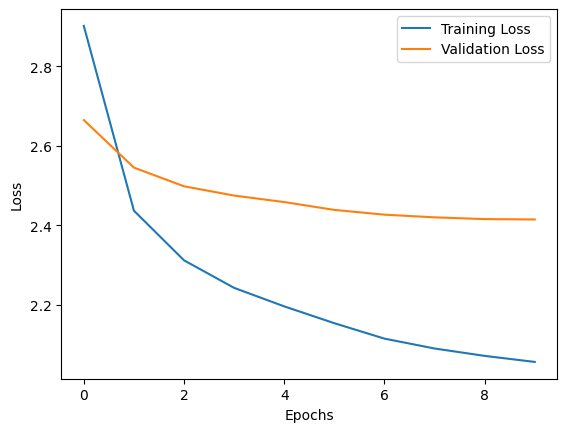

In [28]:
train(megabyte)

# Inference

In [29]:
megabyte.generate(sample_x, decode_fn=decode)

sa- aae 
hatr ctmosd
shoils ueoi  hot eo nibharey  ao lhamh 
uoshhwtrrdntrowe  sioll  regee,,tsbanke 
ronhug,baoeyltgh tnalore:wtycany  liah,,Iaaa dw eae hnvtaylTtoas.a

MI sIvSrMwrmwget toede
wo eoeto,Rfney taeeiog
,ellyitgoas aole te rrsayrdwudol'  slmn
rf,ehbnrdruswcclo
shoutde 'ahws bettnrsdab;dtmsoub eud !etd?eW tiel. 

iA TCiMrsinpop  of eotthrtw;ntcI, Ang soee

hhtvNnr  aed enr khowseo  ehrl nivhn sont,nMirhu,tTy
nur sat,starl'u ,eeoi hiv  ascnpdaes  lakl ,hBmrab,amlA!
Loo  oa.,
aKdea shflr wattfnl,vs hone ahl 
rsvynirgu,nAcL Drky 
frrnul negsl poitne  ir aoh' ,foel,tTsgaolyetl
.u ,tcmant'  nliwhrd rraaedaa ii  eoo  rasmaltd

oe iu teieg  ie hgvosrcd xfner:tIe yruvrniwfdl toat? 
hirk n
tvar ,owgrvso eorn eoc,mtlr sfarr! 
hendernntlr aodi aodtsptest 
ho  eeddssteocsa
estrscfrhw mfstttrnmnhr iot  peo  oi  eadh
ao ehsmkt:dbtrnaoeu 
teues 
oa   erdnpitg nhfut:ts aamh't  ntwlnd;rTsattyra eue;,aoy'  oh wsnywce,ownary  on sr
eib niehet  ngwhrrdniwg c ams dans  oor wtonki
gooe yeuwbrane

# Evaluation